In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('muted')

## Load & Visualize Time Series

In [2]:
eth_price_raw = pd.read_csv('ethereum_price.csv')
df = eth_price_raw[['Date', 'Close']].copy()
df.columns = ['date', 'eth']
df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y')
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,date,eth
0,2015-08-07,2.770000
1,2015-08-08,0.753325
2,2015-08-09,0.701897
3,2015-08-10,0.708448
4,2015-08-11,1.070000


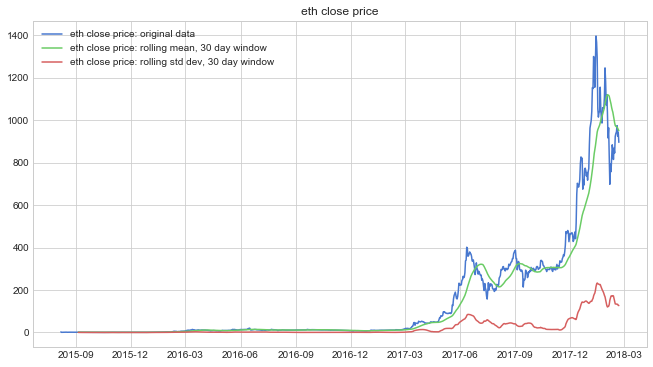

adf: -1.0177344392596426
pval: 0.7467412431946142
critical vals {'1%': -3.4375803238413085, '5%': -2.8647318597670877, '10%': -2.568469555703587}


In [4]:
plt.figure(figsize=(11,6))
plt.plot(
    df['date'],
    df['eth'],
    label='eth close price: original data'
)
plt.plot(
    df['date'],
    df['eth'].rolling(30).mean(),
    label='eth close price: rolling mean, 30 day window'
)
plt.plot(
    df['date'],
    df['eth'].rolling(30).std(),
    label='eth close price: rolling std dev, 30 day window'
)
plt.title('eth close price')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df['eth'])[0],
    adfuller(df['eth'])[1],
    adfuller(df['eth'])[4]))

## Changepoint Detection

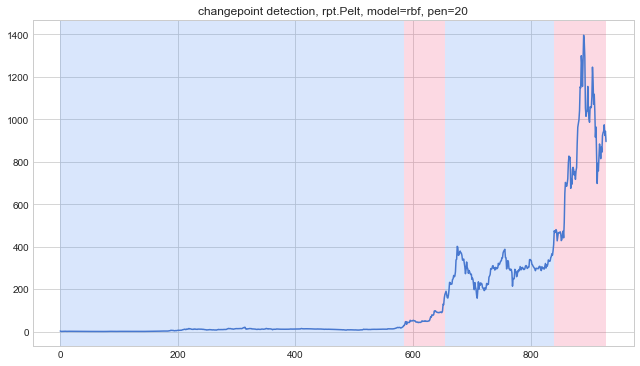

[585, 655, 840, 929]


In [13]:
import ruptures as rpt
ts = df.set_index('date')
cpts = rpt.Pelt(model='rbf').fit_predict(ts, pen=20)

rpt.display(ts, cpts, figsize=(9,5))
plt.title('changepoint detection, rpt.Pelt, model=rbf, pen=20')
plt.show()
print(cpts)

In [72]:
# split df by changepoints
df_01 = df[:585]
df_02 = df[585:655]
df_03 = df[655:840]
df_04 = df[840:929]

#print(len(df_01) + len(df_02) + len(df_03) + len(df_04))
#print(len(df))

In [73]:
# a few attempts at stationarity
df_04['diff_1'] = df_04.eth - df_04.eth.shift(1)
df_04['diff_2'] = df_04.eth - df_04.eth.shift(2)
df_04['log'] = np.log(df_04.eth)
df_04['log_diff_1'] = np.log(df_04.eth).diff().dropna()
df_04['sqrt'] = np.sqrt(df_04.eth)

# drop nans from differencing
df_04 = df_04[2:]
#df_04.head()

print('adf: {0}, npval: {1}, critical vals {2}'.format(
    adfuller(df_04['diff_1'])[0],
    adfuller(df_04['diff_1'])[1],
    adfuller(df_04['diff_1'])[4]))

print('adf: {0}, npval: {1}, critical vals {2}'.format(
    adfuller(df_04['diff_2'])[0],
    adfuller(df_04['diff_2'])[1],
    adfuller(df_04['diff_2'])[4]))

print('adf: {0}, npval: {1}, critical vals {2}'.format(
    adfuller(df_04['log'])[0],
    adfuller(df_04['log'])[1],
    adfuller(df_04['log'])[4]))

print('adf: {0}, npval: {1}, critical vals {2}'.format(
    adfuller(df_04['log_diff_1'])[0],
    adfuller(df_04['log_diff_1'])[1],
    adfuller(df_04['log_diff_1'])[4]))

print('\nsqrt\nadf={0}, pval={1}\ncritical vals={2}'.format(
    adfuller(df_04.sqrt)[0],
    adfuller(df_04.sqrt)[1],
    adfuller(df_04.sqrt)[4]))

adf: -8.505710239830274, npval: 1.2045270363596553e-13, critical vals {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}
adf: -3.365130775019169, npval: 0.01220657353815639, critical vals {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
adf: -1.730401724014338, npval: 0.4155205634322019, critical vals {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}
adf: -8.50830159276226, npval: 1.186277205350465e-13, critical vals {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}

sqrt
adf=-1.7163631212646695, pval=0.42270203493006503
critical vals={'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}


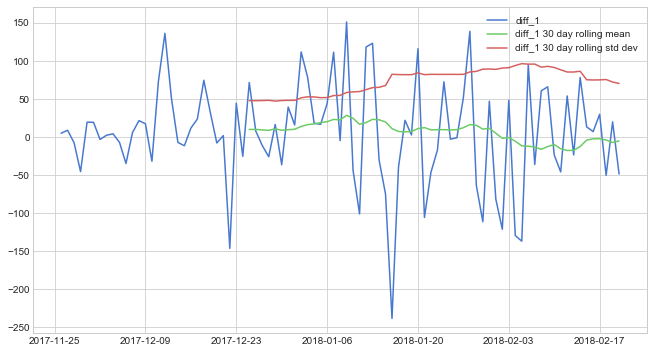

adf: -8.505710239830274
pval: 1.2045270363596553e-13
critical vals {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}


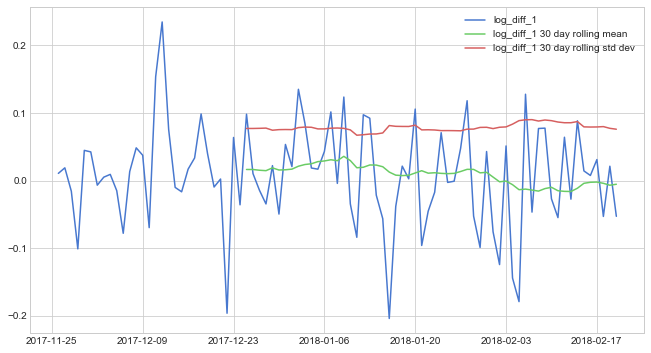

adf: -8.50830159276226
pval: 1.186277205350465e-13
critical vals {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}


In [74]:
window = 30

plt.figure(figsize=(11,6))
plt.plot(df_04.date,
         df_04.diff_1,
         label='diff_1')
plt.plot(df_04.date,
         df_04.diff_1.rolling(window).mean(),
         label='diff_1 {} day rolling mean'.format(window))
plt.plot(df_04.date,
         df_04.diff_1.rolling(window).std(),
         label='diff_1 {} day rolling std dev'.format(window))
plt.legend()
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df_04['diff_1'])[0],
    adfuller(df_04['diff_1'])[1],
    adfuller(df_04['diff_1'])[4]))

plt.figure(figsize=(11,6))
plt.plot(df_04.date,
         df_04.log_diff_1,
         label='log_diff_1')
plt.plot(df_04.date,
         df_04.log_diff_1.rolling(window).mean(),
         label='log_diff_1 {} day rolling mean'.format(window))
plt.plot(df_04.date,
         df_04.log_diff_1.rolling(window).std(),
         label='log_diff_1 {} day rolling std dev'.format(window))
plt.legend()
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df_04['log_diff_1'])[0],
    adfuller(df_04['log_diff_1'])[1],
    adfuller(df_04['log_diff_1'])[4]))

## Autocorrelation Functions (ACF/PACF)

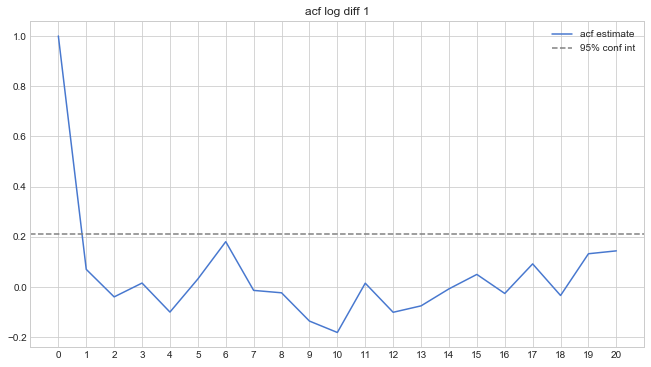

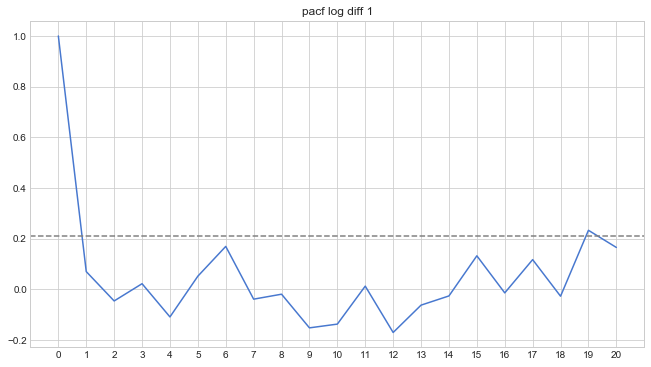

In [75]:
log_diff_1_acf = acf(df_04.log_diff_1, nlags=20)
log_diff_1_pacf = pacf(df_04.log_diff_1, nlags=20, method='ols')

plt.figure(figsize=(11,6))
plt.plot(log_diff_1_acf, label='acf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_04.log_diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('acf log diff 1')
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(log_diff_1_pacf, label='pacf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_04.log_diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('pacf log diff 1')
plt.show()

ARIMA(p,d,q) for eth price
- $p=1$
- $d=1$
- $q=1$

In [87]:
ar1 = ARIMA(df_04.log_diff_1, order=(1,0,0))
ar1_results = ar1.fit()
df_04['ar1_forecast'] = ar1_results.predict(start = len(df_04)-30, end = len(df_04))

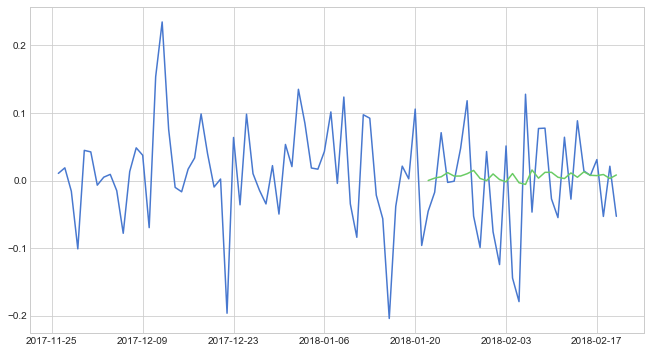

In [88]:
plt.figure(figsize=(11,6))
plt.plot(df_04.date, df_04.log_diff_1, label='actual')
plt.plot(df_04.date, df_04.ar1_forecast, label='forecasted')
plt.show()

In [91]:
print('{0}\n{1}'.format(df_04.date.head(1), df_04.date.tail(1)))

842   2017-11-26
Name: date, dtype: datetime64[ns]
928   2018-02-20
Name: date, dtype: datetime64[ns]


In [249]:
vix_raw = pd.read_csv('vixcurrent.csv', header=1)
print(vix_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 5 columns):
Date         3693 non-null object
VIX Open     3693 non-null float64
VIX High     3693 non-null float64
VIX Low      3693 non-null float64
VIX Close    3693 non-null float64
dtypes: float64(4), object(1)
memory usage: 144.3+ KB
None


In [250]:
vix_raw[:1]

,Date,VIX Open,VIX High,VIX Low,VIX Close
0,1/2/2004,17.96,18.68,17.54,18.22


In [251]:
vix_close = vix_raw[['Date', 'VIX Close']].copy()
vix_close['Date'] = pd.to_datetime(vix_close['Date'], format='%m/%d/%Y')
vix_close.sort_values('Date', inplace=True)
vix_close.reset_index(drop=True, inplace=True)
vix_close.columns = ['date', 'vix']
vix_close.head()

,date,vix
0,2004-01-02,18.22
1,2004-01-05,17.49
2,2004-01-06,16.73
3,2004-01-07,15.50
4,2004-01-08,15.61


In [252]:
vix_close = vix_close.loc[(vix_close['date'] >= '2017-11-26')
                          & (vix_close['date'] <= '2018-02-20')]
vix_close.reset_index(drop=True, inplace=True)

In [253]:
df_04ex = df_04.merge(vix_close, how='outer', on='date')
df_04ex.drop(['diff_2', 'log', 'sqrt', 'ar1_forecast'], axis=1, inplace=True)
df_04ex.vix.ffill(inplace=True)
df_04ex.vix.isnull().sum()

1

In [254]:
df_04ex.head()

,date,eth,diff_1,log_diff_1,vix
0,2017-11-26,471.33,5.05,0.010772,NaN
1,2017-11-27,480.36,9.03,0.018977,9.87
2,2017-11-28,472.90,-7.46,-0.015652,10.03
3,2017-11-29,427.52,-45.38,-0.100883,10.70
4,2017-11-30,447.11,19.59,0.044804,11.28


In [255]:
df_04ex.vix[0]= vix_raw.loc[vix_raw['Date'] == '11/24/2017', ['VIX Close']].values

In [256]:
df_04ex.head()

,date,eth,diff_1,log_diff_1,vix
0,2017-11-26,471.33,5.05,0.010772,9.67
1,2017-11-27,480.36,9.03,0.018977,9.87
2,2017-11-28,472.90,-7.46,-0.015652,10.03
3,2017-11-29,427.52,-45.38,-0.100883,10.70
4,2017-11-30,447.11,19.59,0.044804,11.28


In [257]:
dxy_raw = pd.read_csv('dxy_historical.csv')
dxy_raw[:1]

,Date,Open,High,Low,Close
0,02/20/18,89.24,89.8,89.22,89.72


In [258]:
dxy_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 5 columns):
Date      658 non-null object
 Open     658 non-null float64
 High     658 non-null float64
 Low      658 non-null float64
 Close    658 non-null float64
dtypes: float64(4), object(1)
memory usage: 25.8+ KB


In [259]:
dxy = dxy_raw[['Date', ' Close']].copy()
dxy['Date'] = pd.to_datetime(dxy['Date'], format='%x')
dxy.sort_values('Date', inplace=True)
dxy.reset_index(drop=True, inplace=True)
dxy.columns = ['date', 'dxy']
dxy.head()

,date,dxy
0,2015-08-07,97.56
1,2015-08-10,97.19
2,2015-08-11,97.20
3,2015-08-12,96.29
4,2015-08-13,96.36


In [260]:
dxy = dxy.loc[(dxy['date'] >= '2017-11-26')
                          & (dxy['date'] <= '2018-02-20')]
dxy.reset_index(drop=True, inplace=True)

In [261]:
df_04ex = df_04ex.merge(dxy, how='outer', on='date')
df_04ex.ffill(inplace=True)

# get first value
dxy_raw['Date'] = pd.to_datetime(dxy_raw['Date'], format='%x')
df_04ex.dxy[0] = dxy_raw.loc[dxy_raw['Date'] == '11/24/2017', [' Close']].values
print(df_04ex.dxy.isnull().sum())
df_04ex.head()

0


,date,eth,diff_1,log_diff_1,vix,dxy
0,2017-11-26,471.33,5.05,0.010772,9.67,92.78
1,2017-11-27,480.36,9.03,0.018977,9.87,92.90
2,2017-11-28,472.90,-7.46,-0.015652,10.03,93.27
3,2017-11-29,427.52,-45.38,-0.100883,10.70,93.16
4,2017-11-30,447.11,19.59,0.044804,11.28,93.05


In [262]:
effr_raw = pd.read_csv('EFFR.csv')
effr_raw.head()

,DATE,EFFR
0,2013-09-03,0.09
1,2013-09-04,0.08
2,2013-09-05,0.08
3,2013-09-06,0.08
4,2013-09-09,0.08


In [228]:
df_04ex.ffill(inplace=True)

In [230]:
df_04ex.head()

,date,eth,diff_1,log_diff_1,vix,dxy
0,2017-11-26,471.33,5.05,0.010772,9.67,NaN
1,2017-11-27,480.36,9.03,0.018977,9.87,92.90
2,2017-11-28,472.90,-7.46,-0.015652,10.03,93.27
3,2017-11-29,427.52,-45.38,-0.100883,10.70,93.16
4,2017-11-30,447.11,19.59,0.044804,11.28,93.05


In [231]:
df_04ex.dxy[0]

nan

In [247]:
dxy_raw['Date'] = pd.to_datetime(dxy_raw['Date'], format='%x')
df_04ex.dxy[0] = dxy_raw.loc[dxy_raw['Date'] == '11/24/2017', [' Close']].values

In [248]:
df_04ex.head()

,date,eth,diff_1,log_diff_1,vix,dxy
0,2017-11-26,471.33,5.05,0.010772,9.67,92.78
1,2017-11-27,480.36,9.03,0.018977,9.87,92.90
2,2017-11-28,472.90,-7.46,-0.015652,10.03,93.27
3,2017-11-29,427.52,-45.38,-0.100883,10.70,93.16
4,2017-11-30,447.11,19.59,0.044804,11.28,93.05
